# Post-training Investigation

This notebook uses different methods to assess the quality of generated EEG data. By doing so, we will inform ourselves of possible improvement that can be made to the WGAN's arch to generate more realisitc-looking data.

In [ ]:
# imports
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import sosfilt, butter
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from scipy.signal import welch

import torch
import keras
from sklearn.decomposition import PCA
from src.EEGModalNet.models.WGAN import WGAN_GP

## DATA

In [7]:
# 1. DATA
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channels = ['O1']
filtering = True
time_dim = 1024
n_subject = 202
exclude_sub_ids=['sub-010257', 'sub-010044', 'sub-010266']

# data
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')


sub_ids = xarray.subject[:n_subject].to_numpy()
x = xarray.sel(subject=xarray.subject[:n_subject], channel=channels)
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
x = x.to_numpy()

if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    x = sosfilt(sos, x, axis=-1)
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
pos = xarray.ch_positions[None].repeat(x.shape[0], 0)
data = {'x': x, 'sub': sub, 'pos': pos}

## Visual Inspection of X_gen vs. X

In [59]:
# 2. model
wgan_gp = WGAN_GP(time_dim=1024, feature_dim=1,
                  latent_dim=64, n_subjects=199,
                  use_sublayer_generator=True,
                  use_sublayer_critic=False,
                  use_channel_merger=False)

i=1260
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
wgan_gp.load_weights(model_path)

x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()

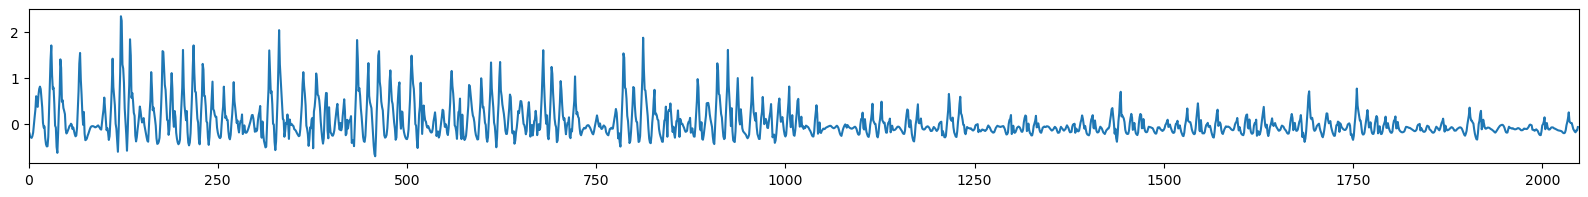

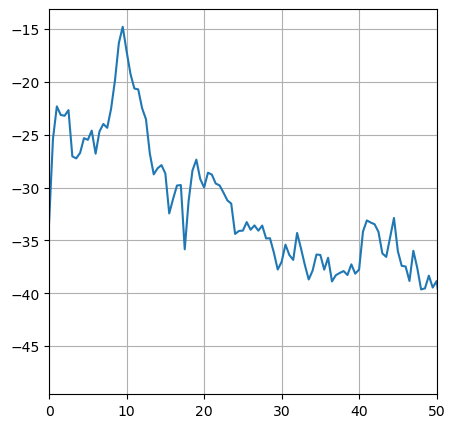

In [64]:
sub = 2
d = 2*1024
s = 10
def plot_segment(x, sub, seg, duration=d, db=False):
    x1 = x[sub*60:(sub+1)*60].flatten()
    plt.figure(figsize=(20, 2))
    segment = x1[seg*duration:(seg+1)*duration]
    plt.plot(segment)
    plt.xlim(0, duration)
    plt.show()
    f, Pxx = welch(segment, fs=128, nperseg=256)
    if db:
        Pxx = 10*np.log10(Pxx)
    plt.figure(figsize=(5, 5))
    plt.plot(f, Pxx)
    plt.xlim(0, 50)
    plt.grid()
    plt.show()

plot_segment(x_gen, sub, s, db=True)

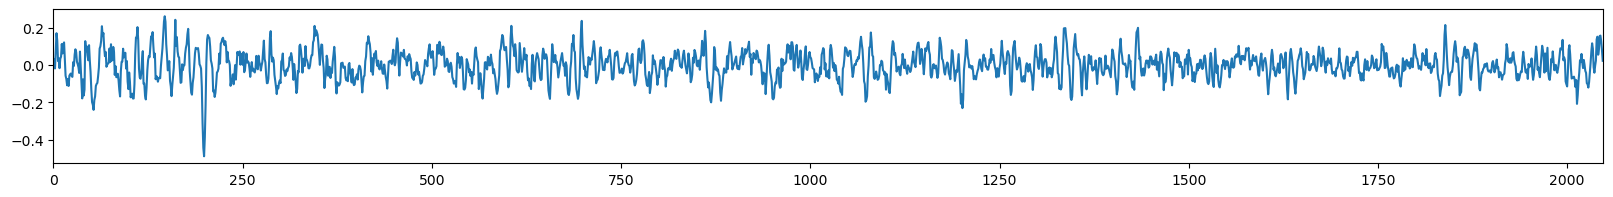

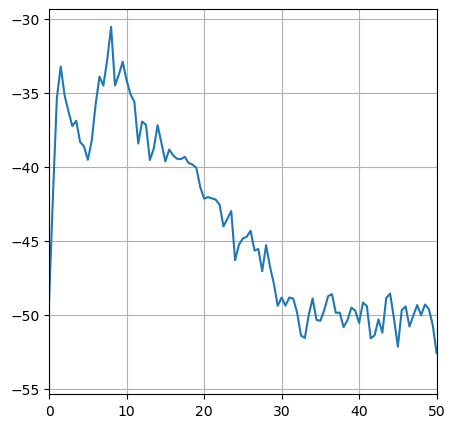

In [63]:
plot_segment(x, sub, s, d, db=True)

## Model & Training

In [ ]:
# 2. MODEL and Plot generated data by the model before training
load_model = False
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=False, kerner_initializer='glorot_uniform',
                  interpolation='bilinear')
if load_model:
    wgan_gp.load_weights('logs/models/F1_5.09.2024.model.keras')

x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                          pos).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
plot_psd(x_gen, fmin=1, ch=0, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=0, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [ ]:
torch.cuda.empty_cache() # clear GPU memory before training
step_losses_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=10.0)

# early stopping callback
callbacks = [keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500),
             step_losses_history]

In [ ]:
# training
batch_size = 64
history = wgan_gp.fit(data, epochs=20, batch_size=batch_size, callbacks=callbacks, shuffle=True)